In [1]:
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
import cv2
from cv2 import cvtColor
import pickle as pkl

%load_ext autoreload
%autoreload 2

In [47]:
def to_grayscale(img):
    original_shape = img.shape[:2]
    img = cvtColor(img,cv2.COLOR_BGR2GRAY).astype(float)
    img /= np.max(img)
    return img
def centroid3(img):
    nx, ny, nz = img.shape
    # print(nx,ny,nz)
    imgx = np.sum(np.sum(img, axis=1), axis=1)
    imgy = np.sum(np.sum(img, axis=2), axis=0)
    imgz = np.sum(np.sum(img, axis=0), axis=0)
    denom = np.sum(np.sum(np.sum(img, axis=0), axis=0), axis=0)
    cx = np.sum(np.linspace(0, nx-1, nx)*imgx)/denom
    cy = np.sum(np.linspace(0, ny-1, ny)*imgy)/denom
    cz = np.sum(np.linspace(0, nz-1, nz)*imgz)/denom
    
    return cx, cy, cz

def plot_img_at(img, coord, label='Target Location',
    vmin = 0.4,
    vmax = 0.8,ax=None):
    '''
        Plot the 3D slicing view of img at coord.
    '''
    img = np.array(img)
    img += -np.min(img)
    img /= np.max(img)
   
    l,p,s = coord
    
    
    target_marker = 'x'
    target_size = 50
    target_color = 'yellow'

  
    if ax is None:
        ax = plt.gca()
    ax.axis('off')
    
    # Only plot the horizontal slice.
    ax.imshow(np.squeeze(img[:,:,s]).T,cmap='gray',vmin=vmin,vmax=vmax)
    ax.scatter(l,p,marker = target_marker,s=target_size,color = target_color,label=label)
    ax.legend()    
    return ax
def visualize_body(img,target_pixel=None,label=None,
                    vmin = 0.4,
                    vmax = 0.8,ax=None):
    img = sitk.GetArrayViewFromImage(img).astype(float)
    img = np.swapaxes(img,0,2)
    if target_pixel is None:
        target_pixel = np.array(centroid3(img))
        label = 'Centroid location'
    plot_img_at(img,np.array(target_pixel,dtype=int),label,vmin,vmax,ax)
    
    
def flip_img(input_img,orders):
    flipped_ct = sitk.Flip(input_img,orders)
    flipped_ct = sitk.GetImageFromArray(sitk.GetArrayFromImage(flipped_ct).astype(np.float64))
    flipped_ct.SetOrigin(input_img.GetOrigin())
    flipped_ct.SetSpacing(input_img.GetSpacing())
    return flipped_ct
def remove_dups(poses):
    non_dups = [poses[0]]
    for i in range(len(poses)-1):
        diff = np.linalg.norm(np.array(poses[i])-np.array(poses[i+1]))*1000
        if diff<1:
            # print(i)
            pass
        else:
            non_dups.append(poses[i+1])
    # non_dups.append(poses[-1])
    return non_dups

In [61]:
with open('us_observations_2.pkl','rb') as fp:
    data = pkl.load(fp)
target_locs = data['CT_target_locs']
frames = data['frame']
poses = data['probe_pose']

body_ct = sitk.ReadImage('./nifty/CT_phantom_regular.nii.gz')
body_ct = flip_img(body_ct,[True,False,False])
ct_x = [t[0] for t in target_locs]
ct_y = [t[-1] for t in target_locs]



poses = remove_dups(poses)
us_y = [-p[0]*1000 for p in poses]
us_x = [-p[1]*1000 for p in poses]

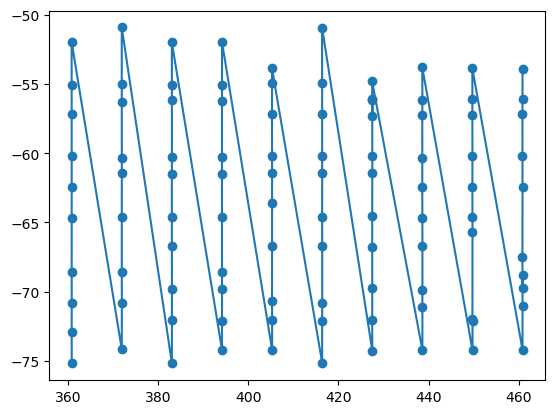

In [56]:
plt.plot(us_x,us_y,marker = 'o')

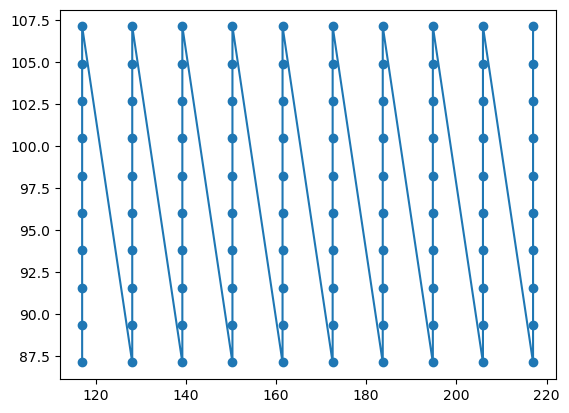

In [57]:
plt.plot(ct_x,ct_y,marker = 'o')

# Do a simple optimization on the translation between the two grids and plot the result

In [62]:
import cvxpy as cp
us = np.vstack([us_x,us_y])
ct = np.vstack([ct_x,ct_y])
dim = 2
offset = cp.Variable((dim,1))
prob = cp.Problem(cp.Minimize(cp.norm(us+offset-ct,'fro')))
prob.solve()

13.282310787864864

In [63]:
shifted_us = us+offset.value

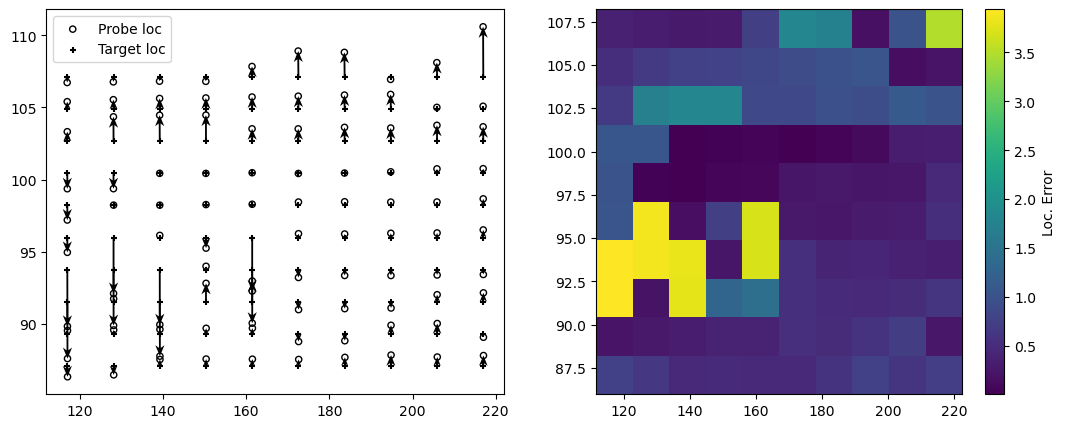

In [64]:
base = ct[:,:]
head = shifted_us[:,:]

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.scatter(head[0,:],head[1,:],s=20,marker='o',facecolors='none', edgecolors='k',label = 'Probe loc')
# plt.scatter(*us)
plt.scatter(base[0,:],base[1,:],s=20,marker = '+',label='Target loc',c='k')
u = head[0,:]-base[0,:]
v = head[1,:]-base[1,:]

plt.quiver(base[0,:],base[1,:],u,v,
           color= 'k',
           angles='xy', scale=1,scale_units='xy',
           width = 0.004,headwidth=5,headlength=6)
plt.legend()
plt.subplot(1,2,2)
c = plt.pcolormesh(base[0,:].reshape(10,10),base[1,:].reshape(10,10),np.sqrt(u**2+v**2).reshape(10,10))
plt.colorbar(c,label='Loc. Error')


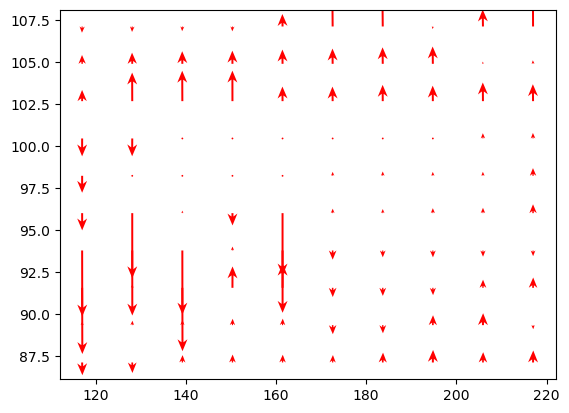

In [65]:
base = ct[:,:]
head = shifted_us[:,:]

u = head[0,:]-base[0,:]
v = head[1,:]-base[1,:]

plt.quiver(base[0,:],base[1,:],u,v,
           color= 'r',
           angles='xy', scale=1,scale_units='xy',
           width = 0.004,headwidth=5,headlength=6)
# plt.legend()